In [2]:
%cd ..

/Users/alexkristoffersen/Desktop/cs184/final_project/Scene2Mesh


In [631]:
import numpy as np
import cv2
import os
import torch
import torchvision


import matplotlib.pyplot as plt
import plyfile
import open3d as o3d
import blenderpy as bpy

import utils.uv
import utils.mesh
import json
import utils.nerf_utils

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def spherical_sample_fn(x):
    '''
    Converts an x value to an rgb color based off of its normal

    Args:
        x: (N, 3)
    Returns:
        col: (N, 3), [0, 1] rgb
    '''
    x = np.abs(x) / np.linalg.norm(x)
    return x


def normuv(uv, H, W):
    """
    Normalize pixel coordinates to lie in [-1, 1]
    
    :param uv (..., 2) unnormalized pixel coordinates for HxW image
    """
    u = uv[..., 0] / H * 2.0 - 1.0
    v = uv[..., 1] / W * 2.0 - 1.0
    return torch.stack([u, v], dim=-1)


def unnormuv(uv, H, W):
    """
    Un-normalize pixel coordinates
    
    :param uv (..., 2) normalized pixel coordinates in [-1, 1]
    """
    u = (uv[..., 0] + 1.0) / 2.0 * H
    v = (uv[..., 1] + 1.0) / 2.0 * W
    return torch.stack([u, v], dim=-1)
    

def get_uv(H, W):
    """
    Get normalized uv coordinates for image
    :param height (int) source image height
    :param width (int) source image width
    :return uv (N, 2) pixel coordinates in [-1.0, 1.0]
    """
    yy, xx = torch.meshgrid(
        (torch.arange(H, dtype=torch.float32) + 0.5),
        (torch.arange(W, dtype=torch.float32) + 0.5),
        indexing='ij',
    )
    uv = torch.stack([xx, yy], dim=-1) # (H, W, 2)
    uv = normuv(uv, W, H) # (H, W, 2)
    return uv.view(H * W, 2)


def create_spherical_uv_sampling(im_shape):
    '''
    creates the sampling of directions from the origin around 360 space.
    Args:
        im_shape: (H, W)
    Returns:
        uv sampling map (H, W)
    '''
    H, W = im_shape
    phis_thetas = get_uv(H, W).numpy() * [np.pi, 2 * np.pi] # phi, theta
    uv_directions = np.column_stack(
        [
            np.sin(phis_thetas[:, 0]) * np.cos(phis_thetas[:, 1]),
            np.sin(phis_thetas[:, 0]) * np.sin(phis_thetas[:, 1]),
            np.cos(phis_thetas[:, 0]),
        ],
    )
    return uv_directions


In [5]:
def get_spherical_coords(X):
    # X is N x 3
    rad = np.linalg.norm(X, axis=1)
    # Inclination
    theta = np.arccos(X[:, 2] / rad)
    # Azimuth
    phi = np.arctan2(X[:, 1], X[:, 0])

    # Normalize both to be between [-1, 1]
    vv = (theta / np.pi) * 2 - 1
    uu = ((phi + np.pi) / (2*np.pi)) * 2 - 1
    # Return N x 2
    return np.stack([uu, vv],1)

In [6]:
def triangle_direction_intersection(tri, trg):
    '''
    Finds where an origin-centered ray going in direction trg intersects a triangle.
    Args:
        tri: 3 X 3 vertex locations. tri[0, :] is 0th vertex.
    Returns:
        alpha, beta, gamma
    '''
    p0 = np.copy(tri[0, :])
    # Don't normalize
    d1 = np.copy(tri[1, :]) - p0
    d2 = np.copy(tri[2, :]) - p0
    d = trg / np.linalg.norm(trg)

    mat = np.stack([d1, d2, d], axis=1)

    try:
      inv_mat = np.linalg.inv(mat)
    except np.linalg.LinAlgError:
      return False, 0
    
    a_b_mg = -1*np.matmul(inv_mat, p0)
    is_valid = (a_b_mg[0] >= 0) and (a_b_mg[1] >= 0) and ((a_b_mg[0] + a_b_mg[1]) <= 1) and (a_b_mg[2] < 0)
    if is_valid:
        return True, -a_b_mg[2]*d
    else:
        return False, 0

In [7]:
def mesh_centroid(vertices, faces):

    return np.average(vertices, axis=0)

def create_spherical_uv_map(H, W, vertices, faces, sample_fn=spherical_sample_fn):
    ray_dirs = create_spherical_uv_sampling((H, W)) # (H * W, 3)
    mesh_center = mesh_centroid(vertices, faces)

    normalized_vertices = vertices - mesh_center
    uv_map = np.zeros((H, W, 3))

    for face in faces:
        pass

    return uv_map

In [8]:
mesh_centroid(
    np.array(
        [
            [1, 1, 1],
            [1, 1, -1],
            [1, -1, -1],
            [1, -1, 1],
            [-1, 1, 1],
            [-1, 1, -1],
            [-1, -1, -1],
            [-1, -1, 1],
        ],
    ),
    np.array(
        [
            [0, 1, 2],
            [0, 2, 3],
            [1, 5, 2],
            [2, 5, 6],
            [3, 2, 6],
            [3, 6, 7],
            [4, 5, 1],
            [4, 1, 0],
            [4, 0, 3],
            [4, 3, 7],
            [4, 5, 6],
            [4, 6, 7],
        ]
    ),
)

array([0., 0., 0.])

In [9]:
get_uv(5, 5).shape

torch.Size([25, 2])

In [10]:
def numpy_to_ply(vertices, faces, vert_colors=None, filename=None):
    '''
    Converts numpy arrays to PLY file, which can be used
    in blender or converted into an obj file.
    Args:
        # vertices: (|V|, 3), <x,y,z>
        # faces: (|F|, 3), vertex indices, 3 for each triangle
        # vert_colors (optional): (|V|, 3) RGB, [0, 1] range
        # filename: string. if not None, write to given filepath.
    Returns:
        PlyData obj
    '''
    assert vertices.shape[1] == 3 and faces.shape[1] == 3

    if vert_colors is None:
        vertices = np.array(
            [tuple(vertices[i]) for i in range(vertices.shape[0])],
            dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')],
        )
    else:
        vertices = np.array(
            [(*vertices[i], vert_colors[i, 0], vert_colors[i, 1], vert_colors[i, 2])  
              for i in range(vertices.shape[0])],
            dtype=[
                ('x', 'f4'), ('y', 'f4'), ('z', 'f4'), 
                ("red", "u1"), ("green", "u1"), ("blue", "u1"),
            ],
        )
    faces = np.array(
        [tuple([faces[i]]) for i in range(faces.shape[0])],
        dtype=[('vertex_indices', 'i4', (3,))],
    )
    ply_data = plyfile.PlyData(
        [
            plyfile.PlyElement.describe(
                vertices, 
                'vertex',
                comments=['model vertices'],
            ),
            plyfile.PlyElement.describe(
                faces,
                'face',
            ),
        ],
    )
    if filename:
        ply_data.write(filename)
    
    return ply_data


In [11]:
unit_box_vertices = np.array(
    [
        [1, 1, 1],
        [1, 1, -1],
        [1, -1, -1],
        [1, -1, 1],
        [-1, 1, 1],
        [-1, 1, -1],
        [-1, -1, -1],
        [-1, -1, 1],
    ],
)

unit_box_faces = np.array(
    [
        [0, 1, 2],
        [0, 2, 3],
        [1, 5, 2],
        [2, 5, 6],
        [3, 2, 6],
        [3, 6, 7],
        [4, 5, 1],
        [4, 1, 0],
        [4, 0, 3],
        [4, 3, 7],
        [4, 5, 6],
        [4, 6, 7],
    ]
)

unit_box_vertex_colors = (255 * (unit_box_vertices + 1) / 2.0).astype(np.uint8)


In [12]:
numpy_to_ply(
    unit_box_vertices, 
    unit_box_faces, 
    vert_colors=unit_box_vertex_colors,
    filename="test.ply",
)

PlyData((PlyElement('vertex', (PlyProperty('x', 'float'), PlyProperty('y', 'float'), PlyProperty('z', 'float'), PlyProperty('red', 'uchar'), PlyProperty('green', 'uchar'), PlyProperty('blue', 'uchar')), count=8, comments=['model vertices']), PlyElement('face', (PlyListProperty('vertex_indices', 'uchar', 'int'),), count=12, comments=[])), text=False, byte_order='<', comments=[], obj_info=[])

In [14]:
test_uv = np.load("test_uv_map.npy", allow_pickle=True)[()]

In [15]:
test_uv

{0: {0: (0.0020020019728690386, 0.3323323428630829),
  1: (0.3323323428630829, 0.3323323428630829),
  2: (0.3323323428630829, 0.0020020019728690386)},
 1: {0: (0.3323323428630829, 0.3353353440761566),
  2: (0.0020020019728690386, 0.6656656861305237),
  3: (0.3323323428630829, 0.6656656861305237)},
 2: {1: (0.6656656861305237, 0.3323323428630829),
  5: (0.3353353440761566, 0.3323323428630829),
  2: (0.6656656861305237, 0.0020020019728690386)},
 3: {2: (0.6656656861305237, 0.3353353440761566),
  5: (0.3353353440761566, 0.6656656861305237),
  6: (0.6656656861305237, 0.6656656861305237)},
 4: {3: (0.0020020019728690386, 0.9989989995956421),
  2: (0.3323323428630829, 0.9989989995956421),
  6: (0.3323323428630829, 0.6686686873435974)},
 5: {3: (0.9989989995956421, 0.0020020019728690386),
  6: (0.6686686873435974, 0.3323323428630829),
  7: (0.9989989995956421, 0.3323323428630829)},
 6: {4: (0.9979979991912842, 0.0010010009864345193),
  5: (0.6676676869392395, 0.0010010009864345193),
  1: (0.6

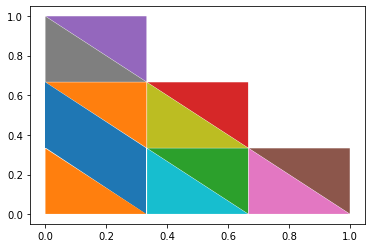

In [16]:
for i in range(12):
    keys = sorted(test_uv[i].keys())
    xs = [test_uv[i][k][0] for k in keys]
    ys = [test_uv[i][k][1] for k in keys]
    plt.fill(xs, ys)

In [67]:
texture_im = utils.uv.draw_texture_map(
    2 * 1024, 
    2 * 1024, 
    unit_box_vertices, #  - np.average(unit_box_vertices, axis=0), 
    test_uv, 
    # sample_fn= red_top # lambda x: np.ones((x.shape[0], 3)),
)

WARNING - 2022-05-04 01:39:31,199 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


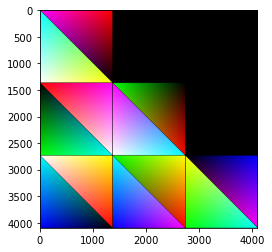

In [18]:
plt.imshow(texture_im)

In [19]:
def red_top(x):
    output = np.zeros((x.shape[0], 3))
    output[x[:, 0] > 0.0] = [1.0, 0.0, 0.0]
    output[x[:, 0] <= 0.0] = [0.0, 0.0, 1.0]

    return output

In [20]:
cv2.imwrite(
    "tex_im.png", 
    cv2.cvtColor((texture_im * 255).astype(np.uint8), cv2.COLOR_RGB2BGR),
)

True

# Chair Demo

In [598]:
chair_verts, chair_faces = utils.mesh.load_obj("/Users/alexkristoffersen/Desktop/cs184/final_project/Scene2Mesh/chair_low_poly.obj")

In [32]:
chair_cols = utils.mesh.extract_cols("/Users/alexkristoffersen/Desktop/cs184/final_project/cloud.txt", len(chair_verts))

177977


In [36]:
numpy_to_ply(
    chair_verts.numpy(), 
    chair_faces.numpy(), 
    vert_colors=(chair_cols * 255).astype(np.uint8),
    filename="chair.ply",
)

PlyData((PlyElement('vertex', (PlyProperty('x', 'float'), PlyProperty('y', 'float'), PlyProperty('z', 'float'), PlyProperty('red', 'uchar'), PlyProperty('green', 'uchar'), PlyProperty('blue', 'uchar')), count=177976, comments=['model vertices']), PlyElement('face', (PlyListProperty('vertex_indices', 'uchar', 'int'),), count=353496, comments=[])), text=False, byte_order='<', comments=[], obj_info=[])

In [39]:
!/Applications/Blender.app/Contents/MacOS/Blender -b -P blender_script.py -- --filepath /Users/alexkristoffersen/Desktop/cs184/final_project/chair.ply



Blender 3.1.2 (hash cc66d1020c3b built 2022-04-01 00:07:11)
Read prefs: /Users/alexkristoffersen/Library/Application Support/Blender/3.1/config/userpref.blend
/Users/alexkristoffersen/Desktop/cs184/final_project/chair.ply
/Users/alexkristoffersen/Desktop/cs184/final_project chair.ply

Successfully imported '/Users/alexkristoffersen/Desktop/cs184/final_project/chair.ply' in 2.616 sec
<bpy_struct, Object("chair") at 0x14f0e8608>

Blender quit


In [592]:
chair_uv = np.load("chair_low_poly_uv_map.npy", allow_pickle=True)[()]

In [593]:
texture_im = utils.uv.draw_texture_map(
    1024, 
    1024, 
    chair_verts.numpy() - np.average(chair_verts.numpy(), axis=0), 
    chair_uv,
    sub_sample=16, 
    # sample_fn= red_top # lambda x: np.ones((x.shape[0], 3)),
)

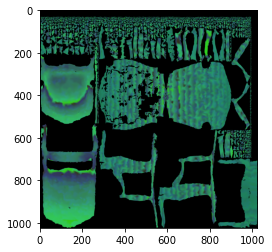

In [594]:
plt.imshow(texture_im)

In [595]:
cv2.imwrite(
    "chair_tex_im.png", 
    cv2.cvtColor((texture_im * 255).astype(np.uint8), cv2.COLOR_RGB2BGR),
)

True

In [100]:
json_chair_fn = "/Users/alexkristoffersen/Desktop/cs184/final_project/chair/transforms_test.json"
imgs_dir = "/Users/alexkristoffersen/Desktop/cs184/final_project/chair/test"

In [144]:
c2ws, camera_angle_x = utils.nerf_utils.create_c2ws(json_chair_fn)
im_names = sorted(
    [fn for fn in os.listdir(imgs_dir) if 'png' in fn and 'depth' not in fn and 'normal' not in fn],
    key = lambda x: int(x[2:-4]),
)
depth_im_names = sorted(
    [fn for fn in os.listdir(imgs_dir) if 'png' in fn and 'depth' in fn and 'normal' not in fn],
    key = lambda x: int(x[2:-15]),
)

In [410]:
ims = np.stack(
    [cv2.cvtColor(cv2.imread(imgs_dir + "/" + im_names[i]), cv2.COLOR_BGR2RGB) 
     for i in range(len(im_names))
    ],
)

depth_ims = np.stack(
    [cv2.imread(imgs_dir + "/" + depth_im_names[i], 0) 
     for i in range(len(depth_im_names))
    ],
)

In [567]:
k = 44
triangle = chair_faces.numpy()[k]
print(triangle)

vertices = np.stack(
    [chair_verts.numpy()[triangle[i]] for i in range(3)]
)
print(vertices)

i = utils.nerf_utils.find_best_im(c2ws, camera_angle_x, ims, depth_ims, vertices)

[28 27 46]
[[-0.6698     -0.08038974 -0.34873128]
 [-0.6736659  -0.08038974 -0.3397668 ]
 [-0.6698     -0.0723381  -0.3397668 ]]
0 145.0
1 116.0
2 116.33333333333333
3 117.66666666666667
4 118.33333333333333
5 119.0
6 120.66666666666667
7 120.66666666666667
8 121.66666666666667
9 123.0
10 123.33333333333333
11 124.0
12 125.33333333333333
13 126.0
14 127.0
15 127.66666666666667
16 128.33333333333334
17 129.0
18 130.0
19 130.33333333333334
20 131.0
21 131.66666666666666
22 132.0
23 132.0
24 133.0
25 133.0
26 133.0
27 133.0
28 134.0
29 134.0
30 134.0
31 134.0
32 133.66666666666666
33 133.33333333333334
34 133.0
35 133.0
36 132.0
37 132.0
38 131.33333333333334
39 131.0
40 130.33333333333334
41 129.33333333333334
42 129.0
43 128.0
44 84.66666666666667
45 127.33333333333333
46 87.66666666666667
47 132.0
48 132.66666666666666
49 132.0
50 132.33333333333334
51 132.0
52 132.0
53 131.66666666666666
54 131.33333333333334
55 131.0
56 131.0
57 130.33333333333334
58 130.33333333333334
59 130.0
60 13

In [568]:
homo_verts = np.hstack([vertices, np.ones((3,1))])

In [569]:
w2c = np.linalg.inv(c2ws[i])
verts_camera_space = w2c @ homo_verts.T

In [570]:
verts_camera_space[:2] /= verts_camera_space[2]

In [571]:
px_coords = (verts_camera_space * utils.nerf_utils.calc_focal(camera_angle_x, 800))[:2].T
print(px_coords)

[[-12.28202276 158.0739306 ]
 [-12.22436201 155.80330083]
 [ -9.70077543 155.29542061]]


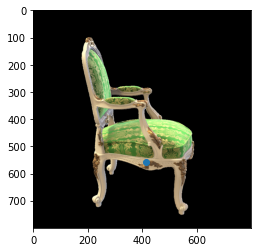

In [611]:
plt.imshow(ims[i])
plt.scatter(
    800 - (px_coords[0, 0] + 400), # x
    px_coords[0, 1] + 400, # y
)
# NOTE: visualizing with this, it goes x, y, but accessing goes y, x

In [635]:
interact(lambda i: plt.imshow(ims[i]), i=widgets.IntSlider(min=0, max=len(ims), step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=200), Output()), _dom_classes=('widget-interact'…

<function __main__.<lambda>(i)>

In [485]:
depth_ims[i][int(px_coords[0, 1] + 400), int(800 - (px_coords[0, 0] + 400))]

142

In [966]:
def draw_texture_map_texture(H, W, vertices, uv_map, gt_ims, gt_depths, c2ws, camera_angle_x, camera_angle_y=None, sub_sample=4):
    '''
        Creates texture map from vertex positions and uv_map.
    Args:
        H: int
        W: int
        vertices: np.array, [|V|, 3]
        uv_map: dict, see format from blender script
        sample_fn: fn that takes in [..., 3], outputs rgbs
        sub_sample: int, increase to decrease aliasing
    Returns:
        result: [H, W, 3]
    '''
    V = vertices.shape[0]
    sqrt_sub = int(np.sqrt(sub_sample))
    buffer = np.zeros((H * sqrt_sub, W * sqrt_sub, 3))

    pixel_offset = 1 / sqrt_sub
    print("total:", len(uv_map))
    for i in range(len(uv_map)): # len(uv_map)
        if i % 100 == 0:
            print(i)
        # print(i)
        loop = uv_map[i]
        vertex_ids = (list(loop.keys()))
        
        v_positions = np.stack(
            [vertices[vertex_ids[i]] for i in range(3)]
        ) # (3, 3)
        # print("v_positions:", v_positions)
        uv_locs = np.stack(
            [loop[vertex_ids[i]] for i in range(3)]
        )
        uv_locs[:, [0, 1]] = uv_locs[:, [1, 0]] # swap
        uv_locs[:, 0] = 1 - uv_locs[:, 0]
        # print("uv_locs:", uv_locs)
         # (3, 2)
        u_min = np.min(uv_locs[:, 0])
        u_max = np.max(uv_locs[:, 0])

        v_min = np.min(uv_locs[:, 1])
        v_max = np.max(uv_locs[:, 1])

        # these uv min/max correspond to locations in the buffer

        buffer_h_min = int(np.floor(u_min * buffer.shape[0]))
        buffer_h_max = min(
            int(np.ceil(u_max * buffer.shape[0])),
            buffer.shape[0] - 1,
        )
        buffer_w_min = int(np.floor(v_min * buffer.shape[1]))
        buffer_w_max = min(
            int(np.ceil(v_max * buffer.shape[1])),
            buffer.shape[1] - 1,
        )

        buffer_locs = np.meshgrid(
            range(buffer_h_min, buffer_h_max),
            range(buffer_w_min, buffer_w_max),
            indexing='ij',
        )
        buffer_hh, buffer_ww = buffer_locs


        # convert these to positions in uv space
        uus = buffer_hh / buffer.shape[0] + 1.0 / (2 * buffer.shape[0])
        vvs = buffer_ww / buffer.shape[1] + 1.0 / (2 * buffer.shape[1])
        uv_positions = np.dstack([uus.ravel(), vvs.ravel()])[0]

        # now i have uv positions, sample the function

        uus = buffer_hh / buffer.shape[0] + 1.0 / (2 * buffer.shape[0])
        vvs = buffer_ww / buffer.shape[1] + 1.0 / (2 * buffer.shape[1])
        uv_positions = np.dstack([uus.ravel(), vvs.ravel()])[0]
        barycentrics = utils.uv.uv_to_barycentric(uv_locs, uv_positions)
        # return buffer_locs
        mask = np.all(barycentrics >= 0.0, axis= 1) * np.all(barycentrics <= 1.0, axis= 1)
        mask *= np.isclose(np.sum(barycentrics, axis=1), 1.0)
        # return ma_box
        # calculate xyzs of each texel

        xyzs = utils.uv.bary_to_xyz(barycentrics, v_positions)
        rgbs = np.zeros_like(xyzs)

        # for indx in range(len(c2ws)):
        best_image_index = utils.nerf_utils.find_best_im(c2ws, camera_angle_x, v_positions, gt_ims, gt_depths)

        sample_im = gt_ims[best_image_index]
        rgbs, mask_oob = utils.nerf_utils.sample_xyzs(sample_im, c2ws[best_image_index], camera_angle_x, xyzs, camera_angle_y=camera_angle_y)
        mask *= ~mask_oob
        ma_box = mask.reshape((buffer_h_max - buffer_h_min, buffer_w_max - buffer_w_min))
        buffer[buffer_h_min: buffer_h_max, buffer_w_min: buffer_w_max][ma_box] = rgbs[mask] # / len(c2ws)
    
    # TODO: average buffer (don't know how to do this yet)
    # buffer = np.flip(buffer, axis=0)
    final_size = buffer.shape[0] // sqrt_sub
    sub_sampled_tex_im = buffer.reshape(
        (final_size, sqrt_sub, final_size, sqrt_sub, 3),
    ).mean(3).mean(1)
    return sub_sampled_tex_im

In [964]:
texture_texture_im = draw_texture_map_texture(
    512, 
    512, 
    chair_verts.numpy(), 
    chair_uv,
    ims,
    depth_ims,
    c2ws,
    camera_angle_x,
    # camera_angle_y=camera_angle_y,
    sub_sample=4,
    # sample_fn= red_top # lambda x: np.ones((x.shape[0], 3)),
)

total: 25402
0


/Users/alexkristoffersen/opt/anaconda3/envs/s2m/lib/python3.7/site-packages/numpy/lib/function_base.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


ValueError: could not broadcast input array from shape (3,3) into shape (3,)

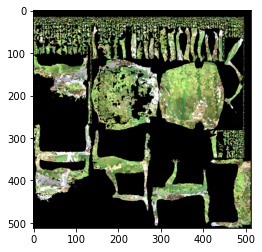

In [643]:
plt.imshow(texture_texture_im / 255)

In [644]:
cv2.imwrite(
    "chair_tex_tex_im_half.png", 
    cv2.cvtColor((texture_texture_im).astype(np.uint8), cv2.COLOR_RGB2BGR),
)

True

# GUM DEMO

In [648]:
gum_verts, gum_faces = utils.mesh.load_obj("/Users/alexkristoffersen/Desktop/cs184/final_project/gum/gum_low_poly.obj")

In [649]:
numpy_to_ply(
    gum_verts.numpy(), 
    gum_faces.numpy(), 
    # filename="gum_low_poly.ply",
)

PlyData((PlyElement('vertex', (PlyProperty('x', 'float'), PlyProperty('y', 'float'), PlyProperty('z', 'float')), count=5735, comments=['model vertices']), PlyElement('face', (PlyListProperty('vertex_indices', 'uchar', 'int'),), count=10003, comments=[])), text=False, byte_order='<', comments=[], obj_info=[])

In [650]:
gum_uv = np.load("gum_low_poly_uv_map.npy", allow_pickle=True)[()]

In [661]:
json_gum_fn = "/Users/alexkristoffersen/Desktop/cs184/final_project/gum/transforms_test.json"
imgs_gum_dir = "/Users/alexkristoffersen/Desktop/cs184/final_project/gum/test"

In [963]:
c2ws, camera_angle_x, camera_angle_y = utils.nerf_utils.create_c2ws(json_gum_fn)
im_names = sorted(
    [fn for fn in os.listdir(imgs_gum_dir) if 'jpg' in fn and 'depth' not in fn and 'normal' not in fn],
    key = lambda x: int(x[:-4]),
)


In [670]:
ims = np.stack(
    [cv2.cvtColor(cv2.imread(imgs_gum_dir + "/" + im_names[i]), cv2.COLOR_BGR2RGB) 
     for i in range(len(im_names))
    ],
)

In [1105]:
texture_texture_im = draw_texture_map_texture(
    1 * 1024, 
    1 * 1024, 
    1.34 * gum_verts.numpy(), 
    gum_uv,
    ims,
    None,
    c2ws,
    camera_angle_x,
    camera_angle_y=camera_angle_y,
    sub_sample=4,
    # sample_fn= red_top # lambda x: np.ones((x.shape[0], 3)),
)

total: 9527
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500


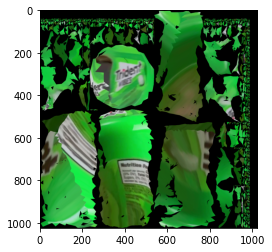

In [1100]:
plt.imshow(texture_texture_im / 255.0)

In [1098]:
cv2.imwrite(
    "gum_tex_tex_im.png", 
    cv2.cvtColor((texture_texture_im).astype(np.uint8), cv2.COLOR_RGB2BGR),
)

True

[27 41 43]
[[-0.72566307  0.686867    0.2575999 ]
 [-0.7407512   0.66942203  0.19365233]
 [-0.73953414  0.64244115  0.24373096]]
151


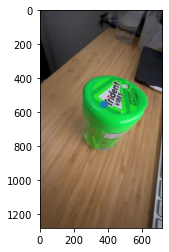

In [908]:
k = 77
triangle = gum_faces.numpy()[k]
print(triangle)

vertices = np.stack(
    [gum_verts.numpy()[triangle[i]] for i in range(3)]
)
print(vertices)

i = utils.nerf_utils.find_best_im(c2ws, camera_angle_x, vertices, ims)

H, W, = ims[i].shape[0], ims[i].shape[1]
w2c = np.linalg.inv(c2ws[i])
homo_xyzs = np.hstack([vertices, np.ones((vertices.shape[0],1))])
verts_camera_space = w2c @ a @ homo_xyzs.T
verts_camera_space[:2] /= verts_camera_space[2]
px_coords = (verts_camera_space * utils.nerf_utils.calc_focal(camera_angle_x, W))[:2].T

px_coords += [W / 2, H / 2]

px_coords[:, 0] = W - px_coords[:, 0] # swap
px_coords[:, [1, 0]] = px_coords[:, [0, 1]]

plt.imshow(ims[i])
plt.scatter(
    (px_coords[:, 1]), # x
    px_coords[:, 0], # y
)
print(i)

In [1101]:
def visualize(i):
    H, W, = ims[i].shape[0], ims[i].shape[1]
    w2c = np.linalg.inv(c2ws[i])
    homo_xyzs = np.hstack([1.34 * gum_verts, np.ones((gum_verts.shape[0],1))])
    homo_xyzs[2]
    a = np.array(
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, -1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
    )
    verts_camera_space = w2c @ a @ homo_xyzs.T
    verts_camera_space[:2] /= verts_camera_space[2]

    im, new_cam_K = utils.nerf_utils.undistort(ims[i])

    # px_coords = (
    #     verts_camera_space[:2].T * \
    #     [utils.nerf_utils.calc_focal(camera_angle_x, W), utils.nerf_utils.calc_focal(camera_angle_y, H)]
    # )
    # px_coords += [359.3, 645.97] # [W / 2, H / 2]
    px_coords = (
        verts_camera_space[:2].T * [new_cam_K[0, 0], new_cam_K[1, 1]]
    )
    px_coords += new_cam_K[:2, 2]

    px_coords[:, 0] = W - px_coords[:, 0] # swap
    px_coords[:, [1, 0]] = px_coords[:, [0, 1]]

    plt.imshow(im)
    plt.scatter(
        (px_coords[:, 1]), # x
        px_coords[:, 0], # y
    )

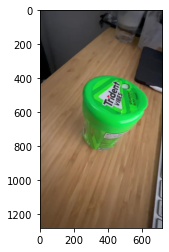

In [1102]:
plt.imshow(ims[i])

In [1103]:
interact(visualize, i=widgets.IntSlider(min=0, max=len(ims), step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=492), Output()), _dom_classes=('widget-interact'…

<function __main__.visualize(i)>

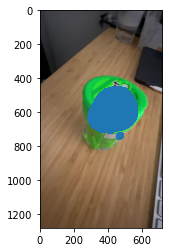

In [1081]:
homo_xyzs = np.hstack([gum_verts, np.ones((gum_verts.shape[0],1))])
a = np.array(
    [
        [-1.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, -1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ],
)
verts_camera_space = w2c @ a @ homo_xyzs.T
verts_camera_space[:2] /= verts_camera_space[2]
px_coords = (
    verts_camera_space[:2].T * \
    [utils.nerf_utils.calc_focal(camera_angle_x, W), utils.nerf_utils.calc_focal(camera_angle_y, H)]
)

px_coords += [W / 2, H / 2]

px_coords[:, 0] = W - px_coords[:, 0] # swap
px_coords[:, [1, 0]] = px_coords[:, [0, 1]]

plt.imshow(ims[i])
plt.scatter(
    (px_coords[:, 1]), # x
    px_coords[:, 0], # y
)

In [1024]:
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_mat, dist_coeffs, (W, H), 1, (W, H))

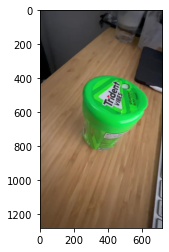

In [1025]:
plt.imshow(ims[i])

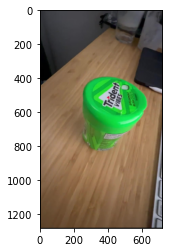

In [1026]:
im_undist = cv2.undistort(ims[i], camera_mat, dist_coeffs, None, newcameramtx)
plt.imshow(im_undist)

In [1029]:
newcameramtx.astype(int)

array([[585,   0, 359],
       [  0, 586, 650],
       [  0,   0,   1]])

In [1051]:
chair2_verts, chair2_faces = utils.mesh.load_obj("/Users/alexkristoffersen/Desktop/cs184/final_project/chair/chair2.obj")

In [1054]:
chair2_cols = utils.mesh.extract_cols(
    "/Users/alexkristoffersen/Desktop/cs184/final_project/chair/chair2.txt", 
    len(chair2_verts),
)

177977


In [1055]:
numpy_to_ply(
    chair2_verts.numpy(), 
    chair2_faces.numpy(), 
    vert_colors=(chair2_cols * 255).astype(np.uint8),
    filename="chair2.ply",
)

PlyData((PlyElement('vertex', (PlyProperty('x', 'float'), PlyProperty('y', 'float'), PlyProperty('z', 'float'), PlyProperty('red', 'uchar'), PlyProperty('green', 'uchar'), PlyProperty('blue', 'uchar')), count=177976, comments=['model vertices']), PlyElement('face', (PlyListProperty('vertex_indices', 'uchar', 'int'),), count=353496, comments=[])), text=False, byte_order='<', comments=[], obj_info=[])

In [1056]:
dozer_verts, dozer_faces = utils.mesh.load_obj("/Users/alexkristoffersen/Desktop/cs184/final_project/dozer/dozer.obj")

In [1057]:
dozer_cols = utils.mesh.extract_cols(
    "/Users/alexkristoffersen/Desktop/cs184/final_project/dozer/dozer.txt", 
    len(dozer_verts),
)

414295


In [1058]:
numpy_to_ply(
    dozer_verts.numpy(), 
    dozer_faces.numpy(), 
    vert_colors=(dozer_cols * 255).astype(np.uint8),
    filename="dozer.ply",
)

PlyData((PlyElement('vertex', (PlyProperty('x', 'float'), PlyProperty('y', 'float'), PlyProperty('z', 'float'), PlyProperty('red', 'uchar'), PlyProperty('green', 'uchar'), PlyProperty('blue', 'uchar')), count=414294, comments=['model vertices']), PlyElement('face', (PlyListProperty('vertex_indices', 'uchar', 'int'),), count=828984, comments=[])), text=False, byte_order='<', comments=[], obj_info=[])

In [1060]:
drum_verts, drum_faces = utils.mesh.load_obj("/Users/alexkristoffersen/Desktop/cs184/final_project/drum/drums.obj")

In [1061]:
drum_cols = utils.mesh.extract_cols(
    "/Users/alexkristoffersen/Desktop/cs184/final_project/drum/drums.txt", 
    len(dozer_verts),
)

224423


In [1062]:
numpy_to_ply(
    drum_verts.numpy(), 
    drum_faces.numpy(), 
    vert_colors=(drum_cols * 255).astype(np.uint8),
    filename="drum.ply",
)

PlyData((PlyElement('vertex', (PlyProperty('x', 'float'), PlyProperty('y', 'float'), PlyProperty('z', 'float'), PlyProperty('red', 'uchar'), PlyProperty('green', 'uchar'), PlyProperty('blue', 'uchar')), count=224422, comments=['model vertices']), PlyElement('face', (PlyListProperty('vertex_indices', 'uchar', 'int'),), count=449196, comments=[])), text=False, byte_order='<', comments=[], obj_info=[])